In [2]:
import sys, os
sys.path.append(os.path.abspath("../src"))
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from utils import load_maf, save_plot, preprocess_maf

# Load and preprocess
maf_raw = load_maf("../data/cohortMAF.2025-07-11.maf")
maf = preprocess_maf(maf_raw)

print(f"Raw MAF shape: {maf_raw.shape}")
print(f"Filtered MAF shape: {maf.shape}")
print(maf[['Hugo_Symbol', 'Variant_Classification', 'Tumor_Sample_Barcode']].head())


# Set up clean plotting
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)


Raw MAF shape: (51065, 140)
Filtered MAF shape: (39708, 140)
  Hugo_Symbol Variant_Classification          Tumor_Sample_Barcode
0       MASP2      Missense_Mutation  TCGA-E2-A158-01A-11D-A12B-09
1       LUZP1        Frame_Shift_Del  TCGA-E2-A158-01A-11D-A12B-09
2       CSMD2      Missense_Mutation  TCGA-E2-A158-01A-11D-A12B-09
4      ADAM30      Missense_Mutation  TCGA-E2-A158-01A-11D-A12B-09
5       CHD1L      Missense_Mutation  TCGA-E2-A158-01A-11D-A12B-09


/var/folders/dw/cp1c7tm95pldv_d3y5p478280000gn/T/ipykernel_53910/1619097806.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Tumor_Sample_Barcode', y='Mutation_Count', data=tmb_top30, palette='viridis')


[✅] Saved: Tumor Mutation Burden → ../figures/01-tmb_per_sample_top30.png


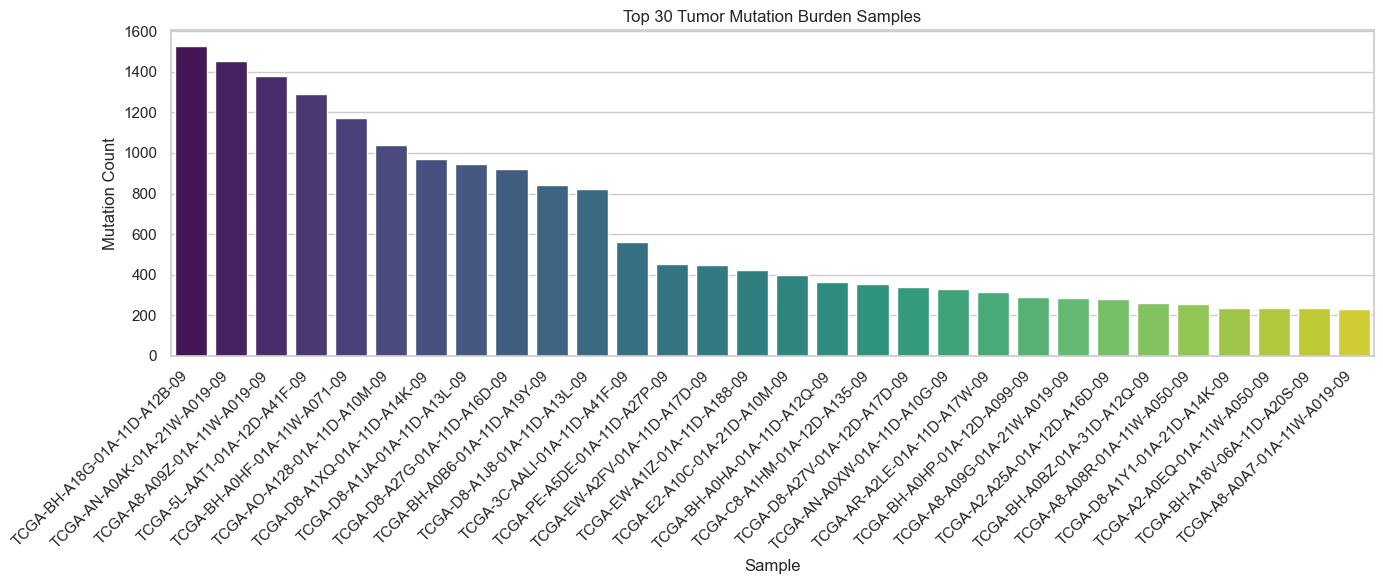

In [5]:
# Step 1: Count mutations per tumor sample
tmb_series = maf_raw['Tumor_Sample_Barcode'].value_counts()
tmb_df = tmb_series.reset_index()
tmb_df.columns = ['Tumor_Sample_Barcode', 'Mutation_Count']

# Step 2: Keep top 30 samples by mutation count
tmb_top30 = tmb_df.head(30)

# Step 3: Plot
plt.figure(figsize=(14, 6))
sns.barplot(x='Tumor_Sample_Barcode', y='Mutation_Count', data=tmb_top30, palette='viridis')

plt.xticks(rotation=45, ha='right')
plt.title("Top 30 Tumor Mutation Burden Samples")
plt.ylabel("Mutation Count")
plt.xlabel("Sample")
plt.tight_layout()

# Save and show
save_plot("tmb_per_sample_top30", step="01", title="Tumor Mutation Burden")
plt.show()


[✅] Saved: Top 10 Mutated Genes in BRCA Cohort → ../figures/02-Top_Mutated_Genes.png


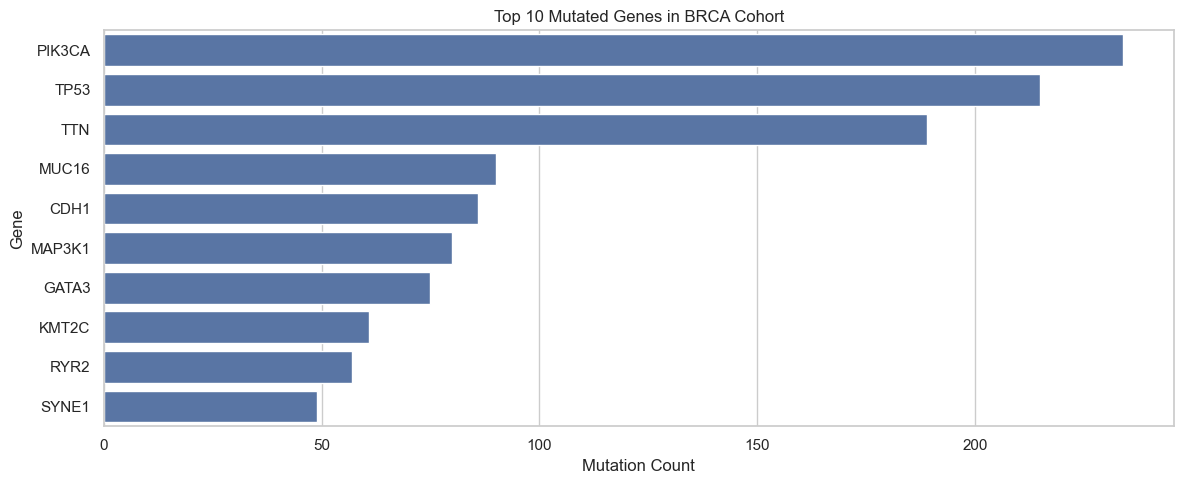

In [6]:
# Top 10 most frequently mutated genes
top_genes = maf_raw['Hugo_Symbol'].value_counts().head(10)

sns.barplot(x=top_genes.values, y=top_genes.index)
plt.title("Top 10 Mutated Genes in BRCA Cohort")
plt.xlabel("Mutation Count")
plt.ylabel("Gene")
plt.tight_layout()

save_plot("Top_Mutated_Genes", step="02", title="Top 10 Mutated Genes in BRCA Cohort")

plt.show()

[✅] Saved: Mutation Classification → ../figures/03-mutation_classification.png


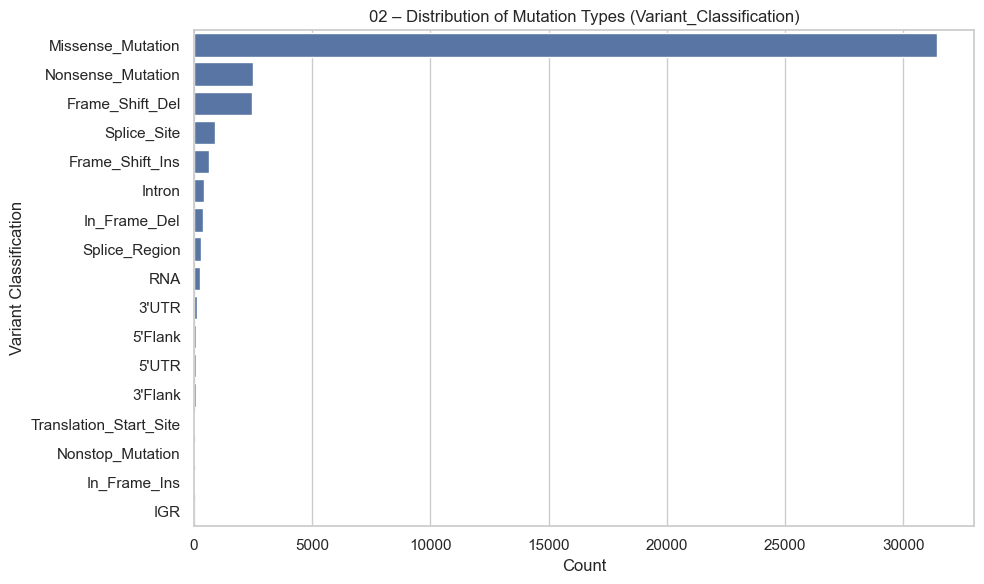

In [7]:
# Count mutation classifications
classification_counts = maf['Variant_Classification'].value_counts()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=classification_counts.values, y=classification_counts.index)
plt.title("02 – Distribution of Mutation Types (Variant_Classification)")
plt.xlabel("Count")
plt.ylabel("Variant Classification")

save_plot("mutation_classification", step="03", title="Mutation Classification")
plt.show()


[✅] Saved: Mutation Types Per Sample (Top 30) → ../figures/04-Mutation_Types_Top30.png


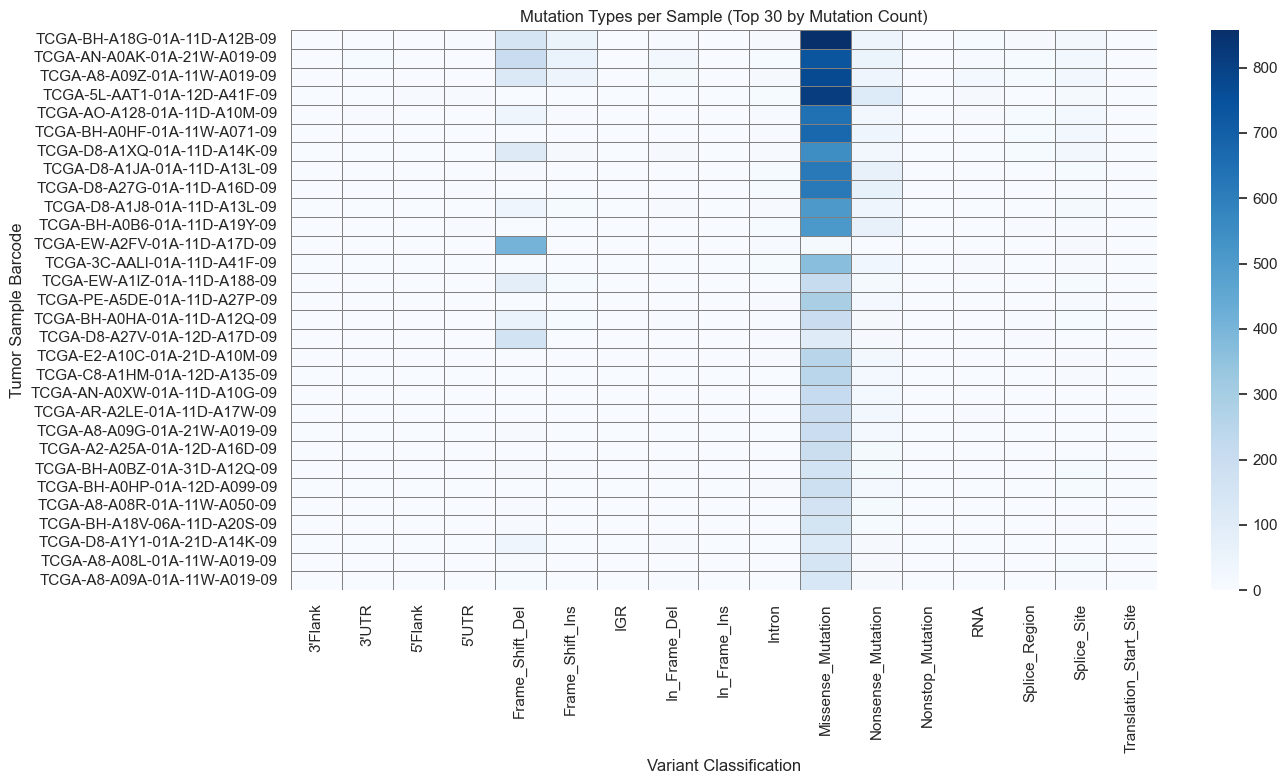

In [9]:
# Step 1: Create pivot table of mutation types per sample
pivot = maf.groupby(['Tumor_Sample_Barcode', 'Variant_Classification']) \
           .size() \
           .unstack(fill_value=0)

# Step 2: Get top 30 samples by total mutation count
top_30_samples = pivot.sum(axis=1).nlargest(30).index

# Step 3: Filter pivot table to top 30 samples
pivot_top30 = pivot.loc[top_30_samples]

# Step 4: Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(pivot_top30, cmap="Blues", linewidths=0.5, linecolor='gray')

plt.title("Mutation Types per Sample (Top 30 by Mutation Count)")
plt.xlabel("Variant Classification")
plt.ylabel("Tumor Sample Barcode")
plt.tight_layout()

# Save and show
save_plot("Mutation_Types_Top30", step="04", title="Mutation Types Per Sample (Top 30)")
plt.show()


In [11]:
import pandas as pd

# Load the OncoKB TSV
oncokb = pd.read_csv("../data/oncokb_cancer_genes.tsv", sep="\t")

# Print first few rows
print(oncokb[['Hugo Symbol', 'Is Oncogene', 'Is Tumor Suppressor Gene']].head())

# Check unique values in the "Is Oncogene" column
print("\nUnique values in 'Is Oncogene':", oncokb['Is Oncogene'].unique())
print("Unique values in 'Is Tumor Suppressor Gene':", oncokb['Is Tumor Suppressor Gene'].unique())


  Hugo Symbol Is Oncogene Is Tumor Suppressor Gene
0        ABL1         Yes                       No
1        AKT1         Yes                       No
2         ALK         Yes                       No
3       AMER1          No                      Yes
4         APC          No                      Yes

Unique values in 'Is Oncogene': ['Yes' 'No']
Unique values in 'Is Tumor Suppressor Gene': ['No' 'Yes']


In [12]:
# Normalize capitalization and whitespace
oncokb['Hugo Symbol'] = oncokb['Hugo Symbol'].str.strip().str.upper()
oncokb['Is Oncogene'] = oncokb['Is Oncogene'].astype(str).str.strip().str.upper()
oncokb['Is Tumor Suppressor Gene'] = oncokb['Is Tumor Suppressor Gene'].astype(str).str.strip().str.upper()

# Filter for drivers
oncokb_drivers = oncokb[
    (oncokb['Is Oncogene'] == 'YES') |
    (oncokb['Is Tumor Suppressor Gene'] == 'YES')
]

# Create driver gene set
driver_genes = set(oncokb_drivers['Hugo Symbol'].dropna().unique())

print(f"Total driver genes found: {len(driver_genes)}")
print(sorted(list(driver_genes))[:10])  # Show a few example genes


Total driver genes found: 791
['ABCB1', 'ABL1', 'ABL2', 'ABRAXAS1', 'ACKR3', 'ACTG1', 'ACVR1', 'ACVR1B', 'ACVR2A', 'ADARB2']


In [13]:
# Standardize your MAF gene symbols
maf['Hugo_Symbol'] = maf['Hugo_Symbol'].str.strip().str.upper()

# Annotate
maf['Is_Driver'] = maf['Hugo_Symbol'].isin(driver_genes)

# Result
print(f" Driver mutations in MAF: {maf['Is_Driver'].sum()} / {len(maf)}")


 Driver mutations in MAF: 3553 / 39708


[✅] Saved: Top 10 Driver Genes (OncoKB) → ../figures/05-top_driver_genes_oncokb.png


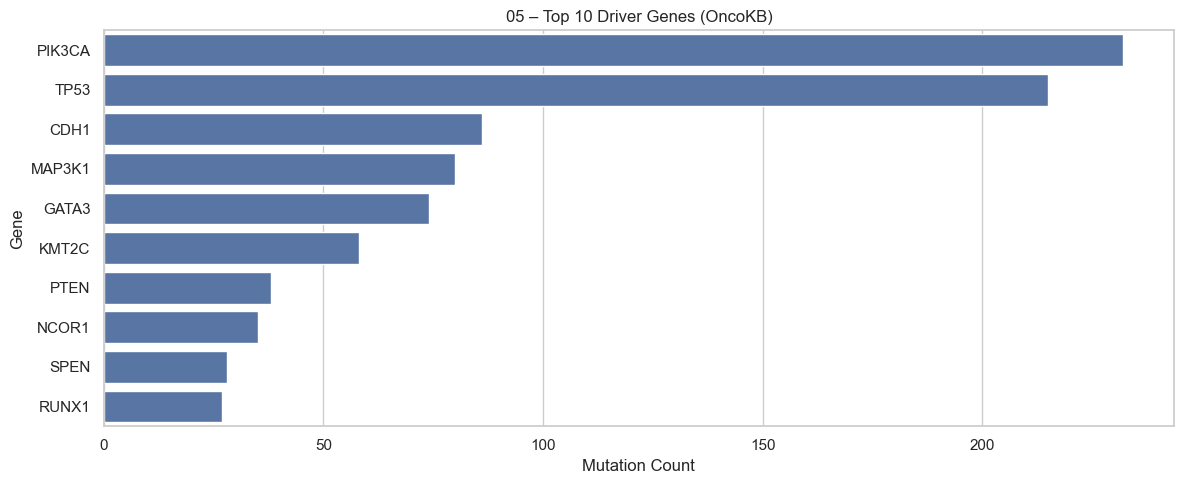

In [14]:
top_drivers = maf[maf['Is_Driver']]['Hugo_Symbol'].value_counts().head(10)

sns.barplot(x=top_drivers.values, y=top_drivers.index)
plt.title("05 – Top 10 Driver Genes (OncoKB)")
plt.xlabel("Mutation Count")
plt.ylabel("Gene")
save_plot("top_driver_genes_oncokb", step="05", title="Top 10 Driver Genes (OncoKB)")
plt.show()


In [15]:
# Get mutated genes
mutated_genes = maf['Hugo_Symbol'].dropna().str.upper().unique().tolist()
print(f"Total unique mutated genes: {len(mutated_genes)}")


Total unique mutated genes: 13448


In [16]:
import gseapy as gp

# Run enrichment using Enrichr libraries (choose one or more)
enr = gp.enrichr(
    gene_list=mutated_genes,
    gene_sets=['GO_Biological_Process_2021', 'KEGG_2021_Human'],
    organism='Human',
    outdir=None  # Don’t save to disk
)

# View top results
enrichment_results = enr.results.sort_values(by='Adjusted P-value').head(10)
enrichment_results[['Term', 'Overlap', 'Adjusted P-value']]


,Term,Overlap,Adjusted P-value
0,protein phosphorylation (GO:0006468),419/496,5.703235e-15
1,phosphorylation (GO:0016310),339/400,2.267525e-12
2,protein autophosphorylation (GO:0046777),148/159,8.094291e-12
3,cellular protein modification process (GO:0006...,787/1025,6.170919e-09
4,neuron projection morphogenesis (GO:0048812),128/140,1.252874e-08
6035,ECM-receptor interaction,84/88,2.934495e-08
5,axonogenesis (GO:0007409),206/240,3.032589e-08
6,extracellular structure organization (GO:0043062),186/216,1.299544e-07
6036,Human papillomavirus infection,271/331,2.205006e-07
6037,Focal adhesion,172/201,2.290665e-07


[✅] Saved: Top Enriched Pathways → ../figures/06-pathway_enrichment_mutated_genes.png


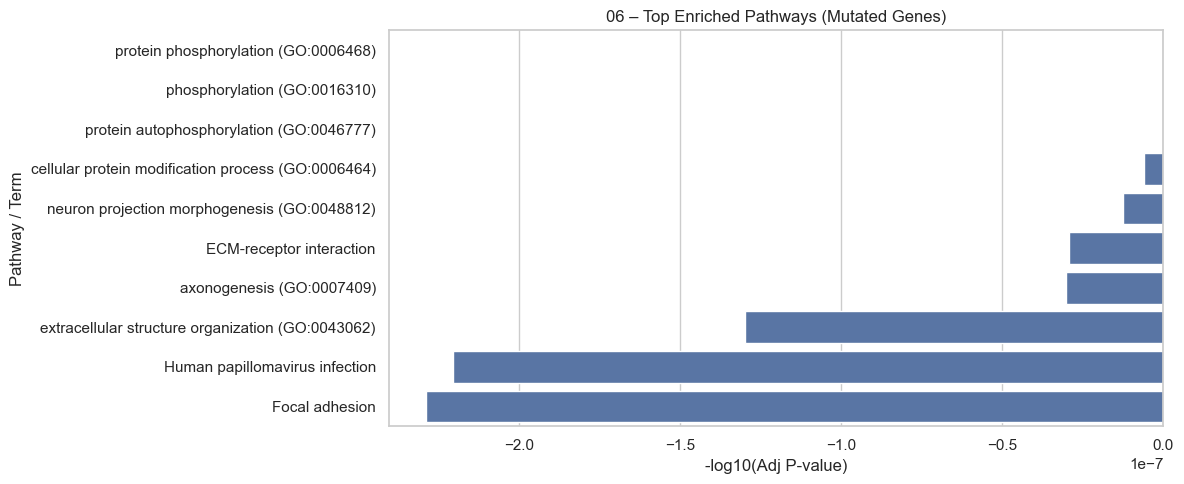

In [17]:
top_terms = enrichment_results.head(10)
sns.barplot(x=-top_terms['Adjusted P-value'], y=top_terms['Term'])
plt.title("06 – Top Enriched Pathways (Mutated Genes)")
plt.xlabel("-log10(Adj P-value)")
plt.ylabel("Pathway / Term")

save_plot("pathway_enrichment_mutated_genes", step="06", title="Top Enriched Pathways")
plt.show()
